In [1]:
from PipelineResources import * # This is where we have all of the resources that will be used in the project. 

The problem occurs because either compilation failed when you installed Somoclu or a path is missing from the dependencies when you are trying to import it. Please refer to the documentation to see your options.


In [2]:
nasdaq = pd.read_pickle('upm_yahoo.pckl')

## Prepare training, validation and test sets

### First Test: Use a Random Forest Model to predict whether or not the next day will close above 1.5 %. 
The goal behind this exercise is to establish a baseline model and performance. In addition, it is also work out the way the data will be stored. 

In [3]:
number_of_samples = nasdaq.index.size
print(" Sample size is: {}".format(number_of_samples))

 Sample size is: 4755


In [4]:
nasdaq.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'open_change', 'open_change_pct', 'next_day_open_change',
       'next_day_open_change_pct', 'open_change_wrt_close',
       'open_change_wrt_close_pct', 'open_change_wrt_high',
       'open_change_wrt_low', 'open_change_wrt_volume',
       'next_day_open_change_wrt_close', 'next_day_open_change_wrt_close_pct',
       'next_day_open_change_wrt_high', 'next_day_open_change_wrt_low',
       'next_day_open_change_wrt_volume', 'close_change_pct', 'close_change',
       'high_change_pct', 'high_change', 'low_change_pct', 'low_change',
       'volume_change_pct', 'volume_change', 'high_low_range',
       'high_low_range_with_ref_open', 'high_low_range_with_ref_open_pct',
       'high_low_range_with_ref_close', 'high_low_range_with_ref_close_pct',
       'gt_1', 'gt_1.5', 'gt_2.5'],
      dtype='object')

In [5]:
#chosen_label = 'gt_2.5'
random_state = 1
x_train, x_val, x_test, y_train, y_val, y_test = get_input_sets(nasdaq, chosen_features, chosen_label, x_test=False,
                                                               number_of_days_per_sample=1)
print(x_train.shape)

number of days per samples: 1
(4751,)
[0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0]
[0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
(4751, 13)
(3563, 13)


In [6]:
x_val, y_val = decrease_class_rows(x_val, y_val, class_number=0, percentage_cut=0.90)
x_train, y_train = decrease_class_rows(x_train, y_train, class_number=0, percentage_cut=0.90)


1075
967
(221,)
(221, 13)
3240
2916
(647,)
(647, 13)


### Apply FFT on the training and validation sets

In [17]:
z_train = []
z_val = []
for row_index in range(x_train.shape[0]):
    z_train.append(get_fft(x_train[row_index], absolute_value=True))
for row_index in range(x_val.shape[0]):
    z_val.append(get_fft(x_val[row_index], absolute_value=True))
z_train = np.array(z_train, dtype=np.float)
z_val = np.array(z_val, dtype=np.float)
x_train = np.concatenate((x_train, z_train), axis=1)
x_val = np.concatenate((x_val, z_val), axis=1)
print(x_train.shape)

(647, 19)


cv scores: [0.66153846 0.68461538 0.66153846 0.68992248 0.6796875 ]
avg score: 0.6754604576624925, std score: 0.011819260845068928, min: 0.6615384615384615, max: 0.689922480620155
Accuracy of random forest TRAINING: 0.75

Classification report:
             precision    recall  f1-score   support

          0       0.74      0.77      0.76       324
          1       0.76      0.72      0.74       323

avg / total       0.75      0.75      0.75       647

Accuracy of random forest VALIDATION: 0.68

Classification report:
             precision    recall  f1-score   support

          0       0.68      0.65      0.66       108
          1       0.68      0.71      0.69       113

avg / total       0.68      0.68      0.68       221



Text(15,0.5,'true labels')

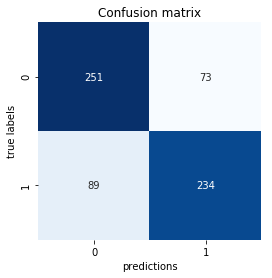

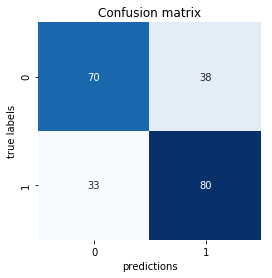

In [7]:
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            #min_samples_leaf=3, min_samples_split=2,
            min_samples_leaf=19, min_samples_split=64,
            min_weight_fraction_leaf=0.02550492908746793,
            n_estimators=13421, n_jobs=24,
            #min_weight_fraction_leaf=0.0, n_estimators=int(x_train.shape[1]/2), n_jobs=10,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

scores = cross_validate(model, x_train, y_train, cv=5, n_jobs=10)
print("cv scores: {}".format(scores['test_score']))
print("avg score: {}, std score: {}, min: {}, max: {}".format(np.mean(scores['test_score']), np.std(scores['test_score']), 
                                                             np.min(scores['test_score']), np.max(scores['test_score'])))

model.fit(x_train, y_train)

pred_test = model.predict(x_train)  # Predict labels of test data using the trained classifier
c_matrix = confusion_matrix(y_train, pred_test) 

rf_accuracy = accuracy_score(y_train, pred_test)
print("Accuracy of random forest TRAINING: {:.2f}".format(rf_accuracy))
print("\nClassification report:")
print(classification_report(y_train, pred_test))

fig, ax = plt.subplots(1, figsize=(4, 4))
ax.set_title("Confusion matrix")
sns.heatmap(c_matrix, cmap='Blues', annot=True, fmt='g', cbar=False)
ax.set_xlabel('predictions')
ax.set_ylabel('true labels')

pred_test = model.predict(x_val)  # Predict labels of test data using the trained classifier
c_matrix = confusion_matrix(y_val, pred_test) 
rf_accuracy = accuracy_score(y_val, pred_test)
print("Accuracy of random forest VALIDATION: {:.2f}".format(rf_accuracy))
print("\nClassification report:")
print(classification_report(y_val, pred_test))

fig, ax = plt.subplots(1, figsize=(4, 4))
ax.set_title("Confusion matrix")
sns.heatmap(c_matrix, cmap='Blues', annot=True, fmt='g', cbar=False)
ax.set_xlabel('predictions')
ax.set_ylabel('true labels')

In [9]:
x_val[0].shape

(13,)

In [23]:
nasdaq[nasdaq['Date'] == '2019-04-03']

,Date,Open,High,Low,Close,Adj Close,Volume,open_change,open_change_pct,next_day_open_change,...,volume_change_pct,volume_change,high_low_range,high_low_range_with_ref_open,high_low_range_with_ref_open_pct,high_low_range_with_ref_close,high_low_range_with_ref_close_pct,gt_1,gt_1.5,gt_2.5
4906,2019-04-03,27.75,28.48,27.700001,28.25,26.949999,1874965.0,0.015739,1.573939,0.018018,...,10.576761,0.105768,0.779999,0.028108,2.810807,0.027611,2.761058,True,True,True


In [39]:
test_nasdaq = nasdaq[nasdaq['Date'] == '2019-04-02']
test_input_df = test_nasdaq[chosen_features]
#print(test_input_df)
#test_input = test_input_df.loc[test_input_df.index.size - 1]
test_input = test_input_df
print(test_input)
test_input = test_input.values.reshape([1, 13])
print(test_input.shape)
model.predict(test_input)

      open_change  next_day_open_change  open_change_wrt_close  \
4905     0.037206              0.015739               0.005151   

      next_day_open_change_wrt_close  high_change  low_change  volume_change  \
4905                        0.010561      0.01393    0.023159      -0.192913   

      high_low_range  close_change  high_low_range_with_ref_close  \
4905        0.709999      0.010302                       0.025856   

      high_low_range_with_ref_open  next_day_open_change_wrt_high  \
4905                      0.025988                       0.003254   

      next_day_open_change_wrt_low  
4905                      0.029685  
(1, 13)


array([1])

Accuracy of random forest TRAINING: 0.86

Classification report:
             precision    recall  f1-score   support

          0       0.90      0.89      0.89       340
          1       0.79      0.81      0.80       182

avg / total       0.86      0.86      0.86       522

Accuracy of random forest VALIDATION: 0.85

Classification report:
             precision    recall  f1-score   support

          0       0.87      0.91      0.89       113
          1       0.83      0.75      0.79        64

avg / total       0.85      0.85      0.85       177



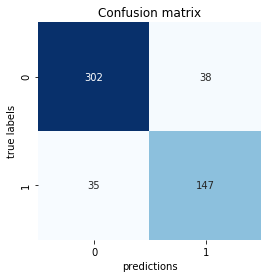

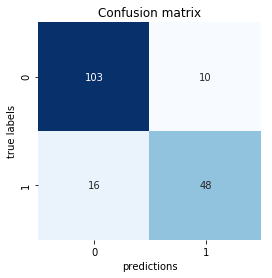

In [11]:
pred_test = model.predict(x_train)  # Predict labels of test data using the trained classifier
c_matrix = confusion_matrix(y_train, pred_test) 

rf_accuracy = accuracy_score(y_train, pred_test)
print("Accuracy of random forest TRAINING: {:.2f}".format(rf_accuracy))
print("\nClassification report:")
print(classification_report(y_train, pred_test))

fig, ax = plt.subplots(1, figsize=(4, 4))
ax.set_title("Confusion matrix")
sns.heatmap(c_matrix, cmap='Blues', annot=True, fmt='g', cbar=False)
ax.set_xlabel('predictions')
ax.set_ylabel('true labels')
plt.savefig(fname='latex/figures/' + 'RF_Training_results' + '.pdf', format='pdf', dpi=300)

pred_test = model.predict(x_val)  # Predict labels of test data using the trained classifier
c_matrix = confusion_matrix(y_val, pred_test) 
rf_accuracy = accuracy_score(y_val, pred_test)
print("Accuracy of random forest VALIDATION: {:.2f}".format(rf_accuracy))
print("\nClassification report:")
print(classification_report(y_val, pred_test))

fig, ax = plt.subplots(1, figsize=(4, 4))
ax.set_title("Confusion matrix")
sns.heatmap(c_matrix, cmap='Blues', annot=True, fmt='g', cbar=False)
ax.set_xlabel('predictions')
ax.set_ylabel('true labels')
plt.savefig(fname='latex/figures/' + 'RF_Test_results' + '.pdf', format='pdf', dpi=300)

In [42]:
model = deepcopy(original_model)

feature name: open_change, importance : 0.03616179749413185
feature name: next_day_open_change, importance : 0.06953324507236841
feature name: open_change_wrt_close, importance : 0.01582359026696802
feature name: next_day_open_change_wrt_close, importance : 0.23851757493714343
feature name: high_change, importance : 0.025996328233172307
feature name: low_change, importance : 0.014742813496094239
feature name: volume_change, importance : 0.012472640315917317
feature name: high_low_range, importance : 0.02634382569674557
feature name: close_change, importance : 0.02217063161356115
feature name: high_low_range_with_ref_close, importance : 0.09153779651387195
feature name: high_low_range_with_ref_open, importance : 0.095119931722202
feature name: next_day_open_change_wrt_high, importance : 0.06490048273082295
feature name: next_day_open_change_wrt_low, importance : 0.19911811862529513


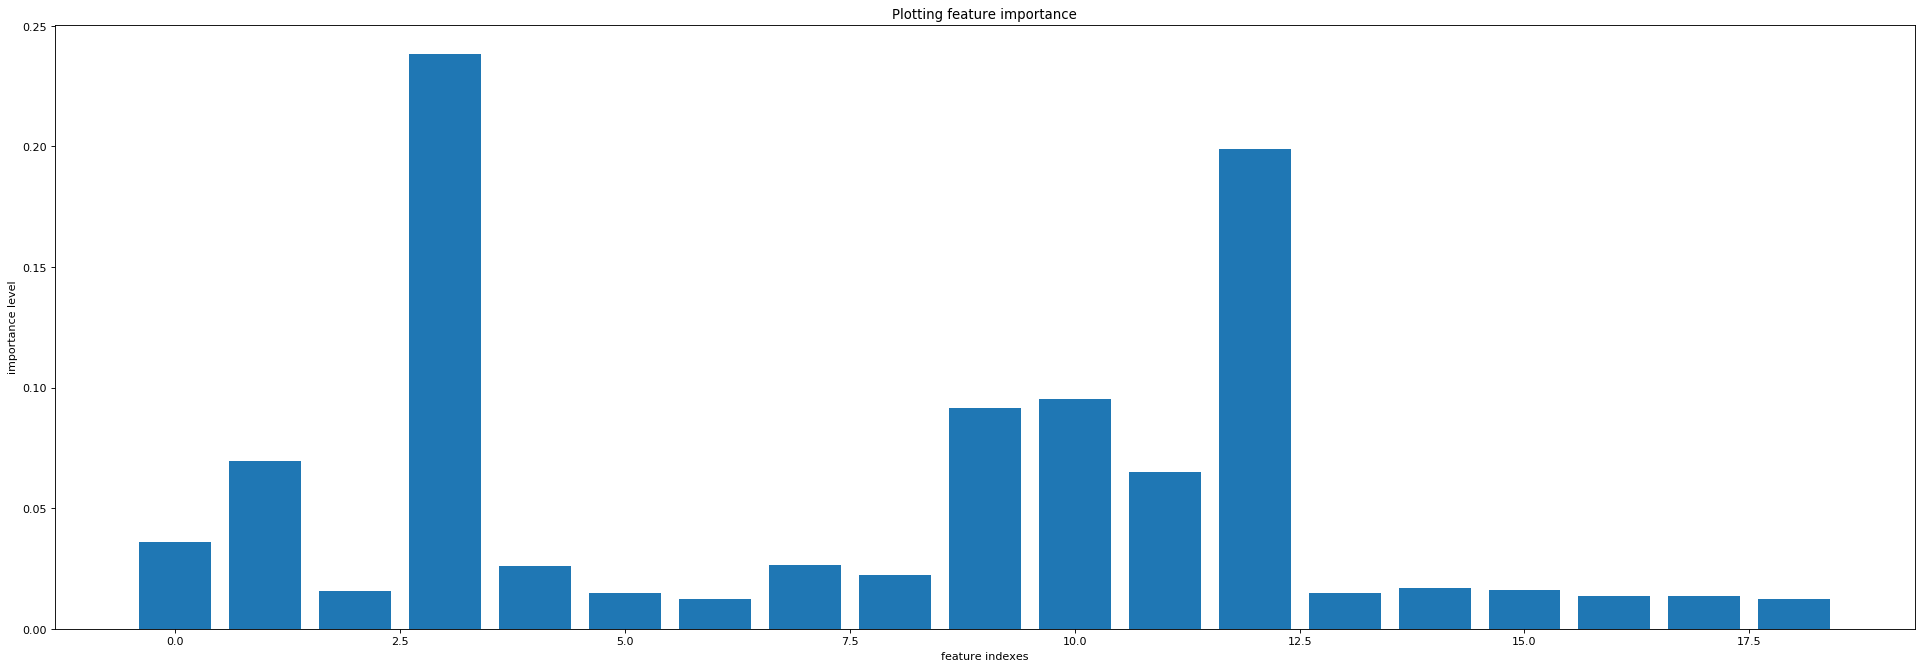

In [19]:
for feature, importance in zip(chosen_features, model.feature_importances_):
    print("feature name: {}, importance : {}".format(feature, importance))
plt.figure( figsize=(30, 10), dpi=80)
plt.title("Plotting feature importance")
plt.ylabel("importance level")
plt.xlabel("feature indexes")
#plt.bar(np.append(chosen_features, np.arange(0,6)), model.feature_importances_)
plt.bar(np.arange(0, len(model.feature_importances_)), model.feature_importances_)
plt.show()

## Hyperparameter Optimization for RF

Accuracy of random forest TRAINING: 0.84

Classification report:
             precision    recall  f1-score   support

          0       0.86      0.96      0.91      3156
          1       0.74      0.40      0.52       852

avg / total       0.83      0.84      0.82      4008

Accuracy of random forest VALIDATION: 0.90

Classification report:
             precision    recall  f1-score   support

          0       0.92      0.97      0.94      1056
          1       0.60      0.38      0.46       138

avg / total       0.88      0.90      0.89      1194



Text(15,0.5,'true labels')

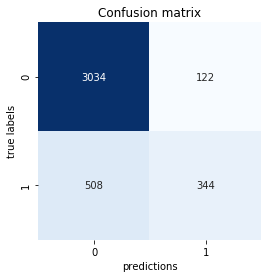

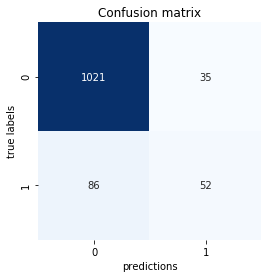

In [51]:
# This is where we attempt to find optimum parameters for the classfier by producing a random search through a grid
# In order to limi computation time, we only visit 10 options. 
M = 50
max_depth = np.array(np.random.uniform(1, 200, M), dtype=int)
min_samples_split = np.array(np.random.uniform(2, 72, M), dtype=int)
a = int(x_train.shape[0] / 10)
b = int(x_train.shape[0] / 0.1)
n_estimators = np.array(np.random.uniform(a, b, M), dtype=int)
min_weight_fraction_leaf= np.random.uniform(0.0, 0.5, M)
min_samples_leaf = np.array(np.random.uniform(2, 50, M), dtype=int)
parameters = {'n_estimators': n_estimators,
             #'max_depth': max_depth, 
             #'min_samples_split': min_samples_split,
             #'min_weight_fraction_leaf': min_weight_fraction_leaf, 
             #'min_samples_leaf': min_samples_leaf
             }

model_test = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=19, min_samples_split=64,
            min_weight_fraction_leaf=0.02550492908746793,
            n_estimators=13421, n_jobs=10,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
#clf = GridSearchCV(model_test, parameters, n_jobs=40)
clf = RandomizedSearchCV(model_test, parameters, refit=True, 
                        n_iter=20, n_jobs=40,
                       cv=3, scoring='f1')
clf.fit(x_train, y_train)
model = clf.best_estimator_
pred_test = model.predict(x_train)  # Predict labels of test data using the trained classifier
c_matrix = confusion_matrix(y_train, pred_test) 

rf_accuracy = accuracy_score(y_train, pred_test)
print("Accuracy of random forest TRAINING: {:.2f}".format(rf_accuracy))
print("\nClassification report:")
print(classification_report(y_train, pred_test))

fig, ax = plt.subplots(1, figsize=(4, 4))
ax.set_title("Confusion matrix")
sns.heatmap(c_matrix, cmap='Blues', annot=True, fmt='g', cbar=False)
ax.set_xlabel('predictions')
ax.set_ylabel('true labels')

pred_test = model.predict(x_val)  # Predict labels of test data using the trained classifier
c_matrix = confusion_matrix(y_val, pred_test) 
rf_accuracy = accuracy_score(y_val, pred_test)
print("Accuracy of random forest VALIDATION: {:.2f}".format(rf_accuracy))
print("\nClassification report:")
print(classification_report(y_val, pred_test))

fig, ax = plt.subplots(1, figsize=(4, 4))
ax.set_title("Confusion matrix")
sns.heatmap(c_matrix, cmap='Blues', annot=True, fmt='g', cbar=False)
ax.set_xlabel('predictions')
ax.set_ylabel('true labels')

In [52]:
model.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=19, min_samples_split=64,
            min_weight_fraction_leaf=0.02550492908746793,
            n_estimators=13421, n_jobs=10, oob_score=False,
            random_state=None, verbose=0, warm_start=False)>

In [10]:
model_dir_path = 'models'
model_filename = "{:s}/{}_random_forest_model_acc-{:2.3f}_{:s}.model".format(
    model_dir_path, 'yahoo_data', rf_accuracy, strftime("%Y_%m_%d_%H_%M_%S", localtime())
)
pickle.dump(model, open(model_filename, 'wb'))